# Tutorial: Goal 2 - Reproduce Original Baseline

This tutorial guides you through implementing and evaluating the linear perturbation prediction model. We'll explore:

1. The linear model Y = A·K·B
2. How to compute gene embeddings (A) and perturbation embeddings (B)
3. How to solve for the interaction matrix K using ridge regression
4. How to make predictions and compute metrics
5. How to compare different baseline methods

## Dataset

We'll use the **Adamson dataset** throughout this tutorial (smallest, fastest dataset).


## 1. Introduction

**Baselines** are simple models that serve as reference points for more complex methods. In perturbation prediction, we use a **linear model**:

**Y = A·K·B**

Where:
- **Y** (genes × perturbations): Expression changes for each gene in each perturbation
- **A** (genes × d_g): Gene embeddings (low-dimensional representations of genes)
- **K** (d_g × d_p): Interaction matrix (learned parameters)
- **B** (d_p × perturbations): Perturbation embeddings (low-dimensional representations of perturbations)

**Ridge regression** is used to solve for K with regularization to prevent overfitting.

The key question: **Which embedding sources (PCA, scGPT, random) enable better predictions?**


## 2. Setup

Let's start by importing libraries and setting up paths.


In [ ]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, spearmanr
import json
import warnings
warnings.filterwarnings('ignore')

# Set up paths (relative to evaluation_framework directory)
NOTEBOOK_DIR = Path.cwd()
EVAL_FRAMEWORK_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "tutorials" else NOTEBOOK_DIR
if NOTEBOOK_DIR.name == "tutorials":
    sys.path.insert(0, str(EVAL_FRAMEWORK_DIR / "src"))

# Dataset paths
ADAMSON_DATA_PATH = EVAL_FRAMEWORK_DIR.parent / "paper" / "benchmark" / "data" / "gears_pert_data" / "adamson" / "perturb_processed.h5ad"
SPLIT_CONFIG_PATH = EVAL_FRAMEWORK_DIR / "results" / "goal_2_baselines" / "splits" / "adamson_split_seed1.json"
OUTPUT_DIR = EVAL_FRAMEWORK_DIR / "tutorials" / "outputs"
INPUT_DIR = OUTPUT_DIR  # Where to load outputs from previous notebooks

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Ask user: Use real data or synthetic data?
print("="*70)
print("DATA SOURCE SELECTION")
print("="*70)
print("Choose a data source:")
print("  1. Real data: Load from Adamson dataset or previous notebook output")
print("  2. Synthetic data: Generate synthetic data (no downloads required)")
print()
USE_REAL_DATA = input("Enter choice (1 for real data, 2 for synthetic): ").strip()
USE_REAL_DATA = USE_REAL_DATA == "1" or USE_REAL_DATA.lower() == "real"

if USE_REAL_DATA:
    # Check if Y matrix exists from previous notebook
    prev_output = INPUT_DIR / "goal_1_Y_matrix.csv"
    if prev_output.exists():
        print(f"\n✓ Found previous output: {prev_output}")
        print("  Will load Y matrix from Goal 1 tutorial")
        USE_PREV_OUTPUT = True
    else:
        USE_PREV_OUTPUT = False
        print("\n✓ Using REAL DATA (loading from files)")
        print(f"  Adamson data: {ADAMSON_DATA_PATH}")
        print(f"  Split config: {SPLIT_CONFIG_PATH}")
        print(f"  Data exists: {ADAMSON_DATA_PATH.exists()}")
        print(f"  Split exists: {SPLIT_CONFIG_PATH.exists()}")
        if not ADAMSON_DATA_PATH.exists() or not SPLIT_CONFIG_PATH.exists():
            print("\n⚠ WARNING: Required files not found. Switching to synthetic data.")
            USE_REAL_DATA = False
else:
    print("\n✓ Using SYNTHETIC DATA (no downloads required)")
    USE_PREV_OUTPUT = False


Adamson data: /Users/samuelminer/Documents/classes/nih_research/linear_perturbation_prediction-Paper/paper/benchmark/data/gears_pert_data/adamson/perturb_processed.h5ad
Split config: /Users/samuelminer/Documents/classes/nih_research/linear_perturbation_prediction-Paper/evaluation_framework/results/goal_2_baselines/splits/adamson_split_seed1.json
Data exists: True
Split exists: True


## 3. Core Concepts

### 3.1 The Linear Model Y = A·K·B

The linear perturbation model decomposes expression changes into three matrices:
- **A**: Gene embeddings (which genes are similar)
- **K**: Interaction matrix (how genes and perturbations interact)
- **B**: Perturbation embeddings (which perturbations are similar)

This decomposition allows us to:
- Share information across similar genes and perturbations
- Make predictions for new perturbations using embeddings
- Learn interpretable representations

### 3.2 Ridge Regression

**Ridge regression** adds a penalty term (λ) to prevent overfitting:
- Minimize: ||Y - A·K·B||² + λ(||K||²)
- Solution: K = (A^T A + λI)^(-1) A^T Y B^T (B B^T + λI)^(-1)

The penalty term (λ) controls the trade-off between fitting the data and keeping K small (regularization).

### 3.3 Metrics

We evaluate predictions using:
- **Pearson r**: Correlation between predicted and true expression changes
- **L2 distance**: Euclidean distance (sqrt(sum((pred - true)²)))
- **MSE**: Mean squared error
- **MAE**: Mean absolute error


## 4. Load Data and Compute Y Matrix

Let's load the Adamson dataset and compute pseudobulk expression changes (Y matrix).


In [ ]:
if USE_PREV_OUTPUT:
    # Load Y matrix from previous notebook
    print(f"Loading Y matrix from: {prev_output}")
    Y_df = pd.read_csv(prev_output, index_col=0)
    print(f"Y matrix shape: {Y_df.shape} (genes × perturbations)")
    
    # Load split configuration
    with open(SPLIT_CONFIG_PATH, 'r') as f:
        split_config = json.load(f)
    
    # Split into train and test
    clean_split_config = {}
    for split_name, conditions in split_config.items():
        clean_split_config[split_name] = [
            cond.replace("+ctrl", "") if "+ctrl" in cond else cond
            for cond in conditions
        ]
    
    train_perts = [p for p in clean_split_config.get("train", []) if p in Y_df.columns]
    test_perts = [p for p in clean_split_config.get("test", []) if p in Y_df.columns]
    
    Y_train = Y_df[train_perts]
    Y_test = Y_df[test_perts] if test_perts else pd.DataFrame()
    
elif USE_REAL_DATA:
    # Load real data
    adata = ad.read_h5ad(ADAMSON_DATA_PATH)
    print(f"AnnData shape: {adata.shape} (cells × genes)")

    # Load split configuration
    with open(SPLIT_CONFIG_PATH, 'r') as f:
        split_config = json.load(f)

    print(f"\nSplit configuration:")
    for split_name, perts in split_config.items():
        print(f"  {split_name}: {len(perts)} perturbations")

    # Compute pseudobulk expression changes (Y matrix)
    # Filter to valid conditions
    all_conditions = []
    for conditions in split_config.values():
        all_conditions.extend(conditions)
    all_conditions = list(set(all_conditions))

    adata_filtered = adata[adata.obs["condition"].isin(all_conditions)].copy()

    # Clean condition names (remove +ctrl suffix)
    adata_filtered.obs["clean_condition"] = (
        adata_filtered.obs["condition"].astype(str).str.replace(r"\+ctrl", "", regex=True)
    )

    # Compute baseline (mean expression in control)
    ctrl_mask = adata_filtered.obs["condition"] == "ctrl"
    baseline = np.asarray(adata_filtered.X[ctrl_mask].mean(axis=0)).ravel()

    # Pseudobulk by condition
    unique_conditions = adata_filtered.obs["clean_condition"].unique()
    pseudobulk_data = []
    condition_labels = []

    for cond in unique_conditions:
        cond_mask = adata_filtered.obs["clean_condition"] == cond
        if cond_mask.sum() == 0:
            continue
        
        cond_expr = adata_filtered.X[cond_mask]
        if hasattr(cond_expr, "toarray"):
            cond_expr = cond_expr.toarray()
        mean_expr = np.asarray(cond_expr.mean(axis=0)).ravel()
        change = mean_expr - baseline
        
        pseudobulk_data.append(change)
        condition_labels.append(cond)

    # Create Y matrix (genes × perturbations)
    Y = np.vstack(pseudobulk_data).T
    gene_names = adata_filtered.var_names.tolist()
    Y_df = pd.DataFrame(Y, index=gene_names, columns=condition_labels)

    print(f"\nY matrix shape: {Y_df.shape} (genes × perturbations)")

    # Split into train and test
    clean_split_config = {}
    for split_name, conditions in split_config.items():
        clean_split_config[split_name] = [
            cond.replace("+ctrl", "") if "+ctrl" in cond else cond
            for cond in conditions
        ]

    train_perts = [p for p in clean_split_config.get("train", []) if p in Y_df.columns]
    test_perts = [p for p in clean_split_config.get("test", []) if p in Y_df.columns]

    Y_train = Y_df[train_perts]
    Y_test = Y_df[test_perts] if test_perts else pd.DataFrame()

else:
    # Generate synthetic data
    print("Generating synthetic Y matrix...")
    np.random.seed(42)
    n_genes = 2000
    n_train_perts = 61
    n_test_perts = 12
    
    # Generate synthetic Y matrix with some structure
    Y_train = pd.DataFrame(
        np.random.randn(n_genes, n_train_perts) * 0.1,
        index=[f"ENSG{i:010d}" for i in range(n_genes)],
        columns=[f"train_pert_{i}" for i in range(n_train_perts)]
    )
    
    Y_test = pd.DataFrame(
        np.random.randn(n_genes, n_test_perts) * 0.1,
        index=Y_train.index,
        columns=[f"test_pert_{i}" for i in range(n_test_perts)]
    )
    
    Y_df = pd.concat([Y_train, Y_test], axis=1)
    train_perts = list(Y_train.columns)
    test_perts = list(Y_test.columns)
    
    print(f"Synthetic Y matrix shape: {Y_df.shape} (genes × perturbations)")

print(f"\nY_train shape: {Y_train.shape} (genes × train perturbations)")
print(f"Y_test shape: {Y_test.shape} (genes × test perturbations)")

# Save outputs if using real data (for use in subsequent notebooks)
if USE_REAL_DATA or USE_PREV_OUTPUT:
    output_file = OUTPUT_DIR / "goal_2_Y_train.csv"
    Y_train.to_csv(output_file)
    output_file = OUTPUT_DIR / "goal_2_Y_test.csv"
    Y_test.to_csv(output_file)
    print(f"\n✓ Saved Y_train and Y_test to: {OUTPUT_DIR}")


AnnData shape: (68603, 5060) (cells × genes)

Split configuration:
  train: 61 perturbations
  test: 12 perturbations
  val: 14 perturbations

Y matrix shape: (5060, 87) (genes × perturbations)
Y_train shape: (5060, 61) (genes × train perturbations)
Y_test shape: (5060, 12) (genes × test perturbations)


## 5. Baseline Models: Ridge Regression & Matrix Factorization

In this section, we'll implement and analyze simple baseline models for predicting gene expression following perturbations. Ridge regression and low-rank matrix factorization serve as interpretable and competitive starting points. These models provide a useful benchmark for evaluating the performance of more sophisticated methods.


In [4]:
def solve_y_axb(Y, A, B, ridge_penalty):
    """
    Solve Y = A·K·B for K using ridge regression.
    
    Args:
        Y: Target matrix (genes × perturbations)
        A: Gene embeddings (genes × d_g)
        B: Perturbation embeddings (d_p × perturbations)
        ridge_penalty: Ridge penalty (λ)
    
    Returns:
        Dictionary with 'K' key containing interaction matrix (d_g × d_p)
    """
    # Check dimensions
    if Y.shape[0] != A.shape[0]:
        raise ValueError(f"Row dimension mismatch: Y has {Y.shape[0]} rows, A has {A.shape[0]} rows")
    if Y.shape[1] != B.shape[1]:
        raise ValueError(f"Column dimension mismatch: Y has {Y.shape[1]} cols, B has {B.shape[1]} cols")
    
    # Ridge regression solution:
    # K = (A^T A + λI)^(-1) A^T Y B^T (B B^T + λI)^(-1)
    
    # Compute regularized A^T A
    AtA = A.T @ A + ridge_penalty * np.eye(A.shape[1])
    
    # Compute regularized B B^T
    BBt = B @ B.T + ridge_penalty * np.eye(B.shape[0])
    
    # Solve for K
    # Step 1: Compute A^T Y B^T
    AtY = A.T @ Y  # (d_g × perts)
    AtYBt = AtY @ B.T  # (d_g × d_p)
    
    # Step 2: Solve (A^T A + λI) X = A^T Y B^T for X
    tmp = np.linalg.solve(AtA, AtYBt)  # (d_g × d_p)
    
    # Step 3: Solve (B B^T + λI) K^T = tmp^T for K^T, then transpose
    K = np.linalg.solve(BBt, tmp.T).T  # (d_g × d_p)
    
    return {"K": K}

# Test the solver with example matrices
print("Testing solve_y_axb function:")
test_Y = np.random.randn(10, 5)
test_A = np.random.randn(10, 3)
test_B = np.random.randn(3, 5)
test_ridge = 0.1

result = solve_y_axb(test_Y, test_A, test_B, test_ridge)
K_test = result["K"]
print(f"K shape: {K_test.shape}")
print(f"Expected: ({test_A.shape[1]}, {test_B.shape[0]})")
print(f"Match: {K_test.shape == (test_A.shape[1], test_B.shape[0])}")


Testing solve_y_axb function:
K shape: (3, 3)
Expected: (3, 3)
Match: True


## 6. Implement Metrics Computation

Let's implement metrics computation inline.


In [11]:
def compute_metrics(y_true, y_pred):
    """
    Compute prediction metrics: Pearson r, Spearman rho, MSE, MAE, L2.
    
    Args:
        y_true: True values (1D array)
        y_pred: Predicted values (1D array)
    
    Returns:
        Dictionary with metrics
    """
    # Mask out non-finite values
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    
    if not np.any(mask):
        return {
            "pearson_r": np.nan,
            "spearman_rho": np.nan,
            "mse": np.nan,
            "mae": np.nan,
            "l2": np.nan,
        }
    
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]
    
    # Pearson correlation
    pearson = pearsonr(y_true_masked, y_pred_masked)[0] if len(y_true_masked) > 1 else np.nan
    
    # Spearman correlation
    spearman = spearmanr(y_true_masked, y_pred_masked)[0] if len(y_true_masked) > 1 else np.nan
    
    # Mean squared error
    mse = np.mean((y_true_masked - y_pred_masked) ** 2)
    
    # Mean absolute error
    mae = np.mean(np.abs(y_true_masked - y_pred_masked))
    
    # L2 distance (Euclidean distance)
    l2 = np.sqrt(np.sum((y_true_masked - y_pred_masked) ** 2))
    
    return {
        "pearson_r": float(pearson),
        "spearman_rho": float(spearman),
        "mse": float(mse),
        "mae": float(mae),
        "l2": float(l2),
    }

# Test the metrics function
print("Testing compute_metrics function:")
test_true = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
test_pred = np.array([1.1, 2.2, 2.9, 4.1, 4.9])
metrics = compute_metrics(test_true, test_pred)
print(f"Metrics: {metrics}")


Testing compute_metrics function:
Metrics: {'pearson_r': 0.9974062482187942, 'spearman_rho': 0.9999999999999999, 'mse': 0.015999999999999993, 'mae': 0.11999999999999993, 'l2': 0.28284271247461895}


## 7. Implement Baseline: Self-Trained (PCA)

Let's implement a complete baseline using PCA embeddings (self-trained). This uses PCA on training data for both gene and perturbation embeddings.


In [13]:
# Parameters
pca_dim = 10
ridge_penalty = 0.1
seed = 1

print(f"Parameters:")
print(f"  PCA dimension: {pca_dim}")
print(f"  Ridge penalty: {ridge_penalty}")
print(f"  Random seed: {seed}")

# Construct gene embeddings (A) using PCA
# A: genes × pca_dim
# We do PCA on Y_train (genes × train_perts), treating genes as observations
gene_pca = PCA(n_components=pca_dim, random_state=seed)
A = gene_pca.fit_transform(Y_train.values)  # genes × pca_dim

print(f"\nGene embeddings (A) shape: {A.shape} (genes × {pca_dim})")
print(f"Explained variance ratio (first 5 PCs): {gene_pca.explained_variance_ratio_[:5]}")
print(f"Cumulative explained variance: {gene_pca.explained_variance_ratio_.cumsum()[:5]}")

# Construct perturbation embeddings (B) using PCA
# B_train: pca_dim × train_perts
pert_pca = PCA(n_components=pca_dim, random_state=seed)
pert_emb_train = pert_pca.fit_transform(Y_train.values.T)  # train_perts × pca_dim
B_train = pert_emb_train.T  # pca_dim × train_perts

# Transform test perturbations if available
if not Y_test.empty:
    pert_emb_test = pert_pca.transform(Y_test.values.T)  # test_perts × pca_dim
    B_test = pert_emb_test.T  # pca_dim × test_perts
else:
    B_test = None

print(f"\nPerturbation embeddings (B_train) shape: {B_train.shape} (pca_dim × train_perts)")
if B_test is not None:
    print(f"Perturbation embeddings (B_test) shape: {B_test.shape} (pca_dim × test_perts)")
print(f"Explained variance ratio (first 5 PCs): {pert_pca.explained_variance_ratio_[:5]}")
print(f"Cumulative explained variance: {pert_pca.explained_variance_ratio_.cumsum()[:5]}")


Parameters:
  PCA dimension: 10
  Ridge penalty: 0.1
  Random seed: 1

Gene embeddings (A) shape: (5060, 10) (genes × 10)
Explained variance ratio (first 5 PCs): [0.61772263 0.14744689 0.04341727 0.02979902 0.02520056]
Cumulative explained variance: [0.61772263 0.7651695  0.8085868  0.8383858  0.86358637]

Perturbation embeddings (B_train) shape: (10, 61) (pca_dim × train_perts)
Perturbation embeddings (B_test) shape: (10, 12) (pca_dim × test_perts)
Explained variance ratio (first 5 PCs): [0.32693478 0.26617053 0.0674919  0.05201699 0.03762968]
Cumulative explained variance: [0.32693478 0.5931053  0.6605972  0.7126142  0.75024384]


## 8. Solve for K and Make Predictions

Now let's solve for the interaction matrix K and make predictions on test data.


In [14]:
# Solve for K using ridge regression
Y_train_array = Y_train.values  # genes × train_perts
solution = solve_y_axb(Y_train_array, A, B_train, ridge_penalty)
K = solution["K"]

print(f"Interaction matrix K shape: {K.shape} (d_g × d_p)")
print(f"K statistics:")
print(f"  Mean: {K.mean():.4f}")
print(f"  Std:  {K.std():.4f}")
print(f"  Min:  {K.min():.4f}")
print(f"  Max:  {K.max():.4f}")

# Make predictions on test data
if not Y_test.empty and B_test is not None:
    # Y_pred = A @ K @ B_test
    Y_pred = A @ K @ B_test  # genes × test_perts
    
    print(f"\nPredictions shape: {Y_pred.shape} (genes × test_perts)")
    print(f"True values shape: {Y_test.shape} (genes × test_perts)")
    
    # Compute per-perturbation metrics
    per_pert_metrics = []
    for pert_idx, pert_name in enumerate(test_perts):
        y_true = Y_test[pert_name].values
        y_pred = Y_pred[:, pert_idx]
        metrics = compute_metrics(y_true, y_pred)
        metrics["perturbation"] = pert_name
        per_pert_metrics.append(metrics)
    
    results_df = pd.DataFrame(per_pert_metrics)
    
    print(f"\nPer-perturbation metrics (first 5):")
    print(results_df.head())
    
    print(f"\nAverage metrics:")
    print(f"  Mean Pearson r: {results_df['pearson_r'].mean():.4f}")
    print(f"  Mean L2: {results_df['l2'].mean():.4f}")
    print(f"  Mean MSE: {results_df['mse'].mean():.4f}")
else:
    print("\nNo test data available for evaluation")
    results_df = None


Interaction matrix K shape: (10, 10) (d_g × d_p)
K statistics:
  Mean: -0.0036
  Std:  0.0446
  Min:  -0.1767
  Max:  0.1278

Predictions shape: (5060, 12) (genes × test_perts)
True values shape: (5060, 12) (genes × test_perts)

Per-perturbation metrics (first 5):
   pearson_r  spearman_rho       mse       mae        l2 perturbation
0   0.788172      0.595657  0.008083  0.048530  6.395502         AARS
1   0.356248      0.236416  0.007875  0.043947  6.312624        CHERP
2   0.384867      0.299825  0.005713  0.038027  5.376527        DDOST
3   0.787596      0.534187  0.005667  0.041160  5.354884       EIF2B2
4   0.822124      0.572734  0.005716  0.041527  5.377981       EIF2B3

Average metrics:
  Mean Pearson r: 0.5615
  Mean L2: 5.5638
  Mean MSE: 0.0061


## 9. Compare Multiple Baselines

Now let's compare different baseline methods: Self-trained (PCA), Random embeddings, and optionally scGPT if available.


In [15]:
def run_baseline(Y_train, Y_test, gene_emb_source, pert_emb_source, pca_dim, ridge_penalty, seed):
    """
    Run a baseline with specified embedding sources.
    
    Args:
        Y_train: Training data (genes × train_perts)
        Y_test: Test data (genes × test_perts)
        gene_emb_source: "training_data" or "random"
        pert_emb_source: "training_data" or "random"
        pca_dim: PCA dimension
        ridge_penalty: Ridge penalty
        seed: Random seed
    
    Returns:
        Dictionary with baseline name and metrics
    """
    baseline_name = f"gene_{gene_emb_source}_pert_{pert_emb_source}"
    
    # Construct gene embeddings (A)
    if gene_emb_source == "training_data":
        gene_pca = PCA(n_components=pca_dim, random_state=seed)
        A = gene_pca.fit_transform(Y_train.values)
    elif gene_emb_source == "random":
        rng = np.random.default_rng(seed)
        A = rng.normal(0, 1, size=(Y_train.shape[0], pca_dim))
    else:
        raise ValueError(f"Unknown gene embedding source: {gene_emb_source}")
    
    # Construct perturbation embeddings (B)
    if pert_emb_source == "training_data":
        pert_pca = PCA(n_components=pca_dim, random_state=seed)
        pert_emb_train = pert_pca.fit_transform(Y_train.values.T)
        B_train = pert_emb_train.T
        
        if not Y_test.empty:
            pert_emb_test = pert_pca.transform(Y_test.values.T)
            B_test = pert_emb_test.T
        else:
            B_test = None
    elif pert_emb_source == "random":
        rng = np.random.default_rng(seed)
        B_train = rng.normal(0, 1, size=(pca_dim, Y_train.shape[1]))
        
        if not Y_test.empty:
            B_test = rng.normal(0, 1, size=(pca_dim, Y_test.shape[1]))
        else:
            B_test = None
    else:
        raise ValueError(f"Unknown perturbation embedding source: {pert_emb_source}")
    
    # Solve for K
    solution = solve_y_axb(Y_train.values, A, B_train, ridge_penalty)
    K = solution["K"]
    
    # Make predictions
    if not Y_test.empty and B_test is not None:
        Y_pred = A @ K @ B_test
        
        # Compute metrics
        per_pert_metrics = []
        for pert_idx, pert_name in enumerate(Y_test.columns):
            y_true = Y_test[pert_name].values
            y_pred = Y_pred[:, pert_idx]
            metrics = compute_metrics(y_true, y_pred)
            metrics["perturbation"] = pert_name
            per_pert_metrics.append(metrics)
        
        results_df = pd.DataFrame(per_pert_metrics)
        
        # Aggregate metrics
        avg_metrics = {
            "baseline": baseline_name,
            "mean_pearson_r": results_df["pearson_r"].mean(),
            "mean_l2": results_df["l2"].mean(),
            "mean_mse": results_df["mse"].mean(),
            "mean_mae": results_df["mae"].mean(),
            "std_pearson_r": results_df["pearson_r"].std(),
            "std_l2": results_df["l2"].std(),
        }
    else:
        avg_metrics = {
            "baseline": baseline_name,
            "mean_pearson_r": np.nan,
            "mean_l2": np.nan,
            "mean_mse": np.nan,
            "mean_mae": np.nan,
            "std_pearson_r": np.nan,
            "std_l2": np.nan,
        }
    
    return avg_metrics, results_df if not Y_test.empty else None

# Run multiple baselines
baselines_to_run = [
    ("training_data", "training_data", "Self-trained (PCA on both)"),
    ("random", "training_data", "Random gene embeddings"),
    ("training_data", "random", "Random pert embeddings"),
    ("random", "random", "Random (both)"),
]

all_results = []
all_per_pert_results = []

for gene_source, pert_source, name in baselines_to_run:
    print(f"\nRunning baseline: {name}")
    avg_metrics, per_pert_df = run_baseline(
        Y_train, Y_test, gene_source, pert_source, pca_dim, ridge_penalty, seed
    )
    avg_metrics["display_name"] = name
    all_results.append(avg_metrics)
    if per_pert_df is not None:
        per_pert_df["baseline"] = name
        all_per_pert_results.append(per_pert_df)

# Summary table
summary_df = pd.DataFrame(all_results)
print("\n" + "="*70)
print("BASELINE COMPARISON SUMMARY")
print("="*70)
print(summary_df[["display_name", "mean_pearson_r", "mean_l2", "mean_mse"]].to_string(index=False))



Running baseline: Self-trained (PCA on both)

Running baseline: Random gene embeddings

Running baseline: Random pert embeddings

Running baseline: Random (both)

BASELINE COMPARISON SUMMARY
              display_name  mean_pearson_r  mean_l2  mean_mse
Self-trained (PCA on both)        0.561457 5.563825  0.006148
    Random gene embeddings        0.026174 6.823403  0.009536
    Random pert embeddings       -0.320484 9.038739  0.018382
             Random (both)       -0.008013 6.837507  0.009577


### 10. Baseline Comparison Visualization


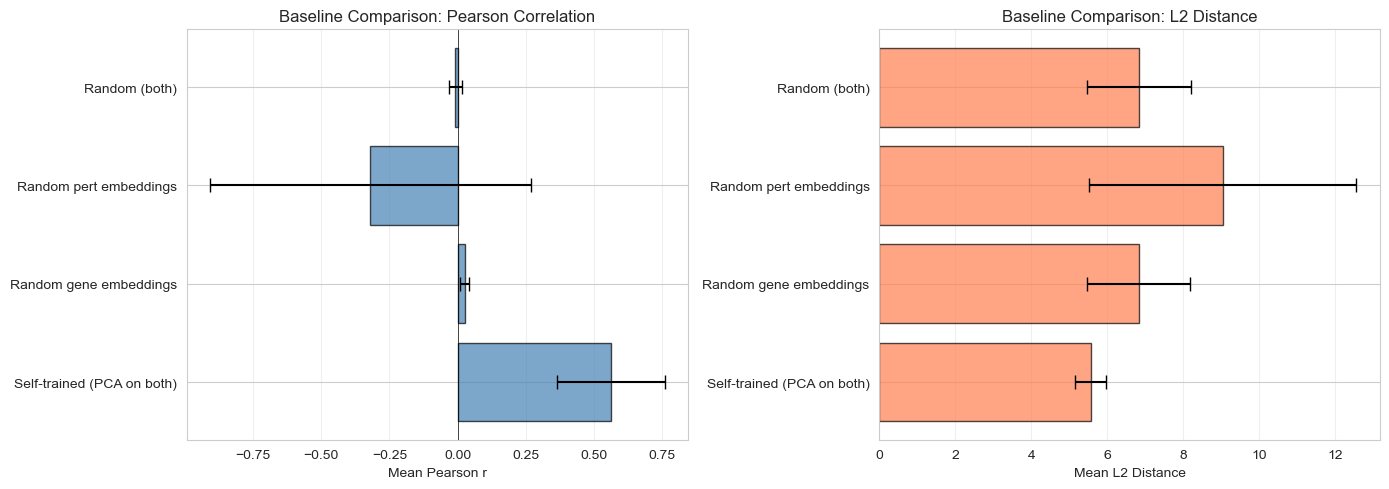

In [16]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

# Plot 1: Baseline comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pearson r comparison
axes[0].barh(summary_df["display_name"], summary_df["mean_pearson_r"], 
             xerr=summary_df["std_pearson_r"], alpha=0.7, color='steelblue', edgecolor='black', capsize=5)
axes[0].set_xlabel('Mean Pearson r')
axes[0].set_title('Baseline Comparison: Pearson Correlation')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].axvline(0, color='black', linestyle='-', linewidth=0.5)

# L2 comparison
axes[1].barh(summary_df["display_name"], summary_df["mean_l2"], 
             xerr=summary_df["std_l2"], alpha=0.7, color='coral', edgecolor='black', capsize=5)
axes[1].set_xlabel('Mean L2 Distance')
axes[1].set_title('Baseline Comparison: L2 Distance')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


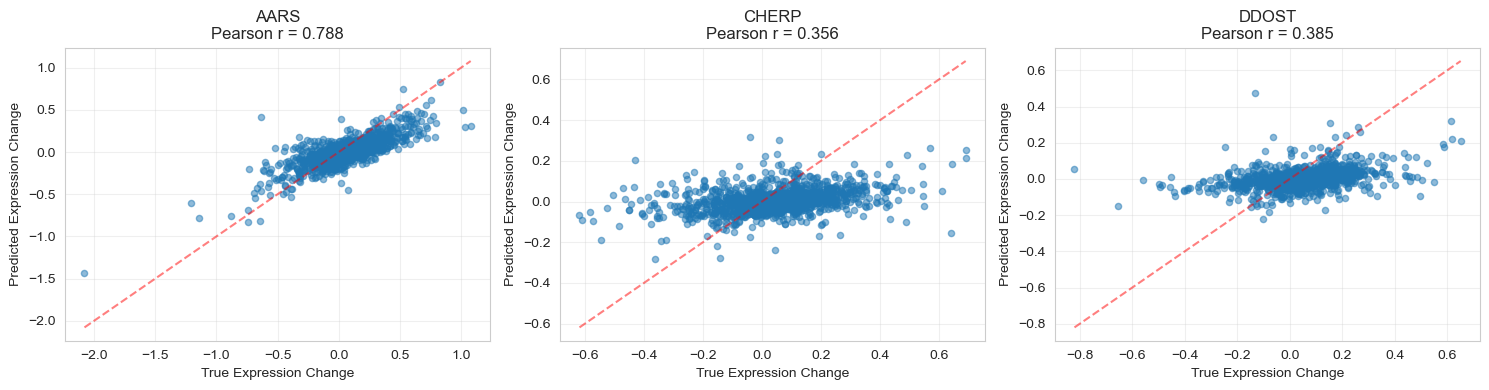

In [17]:
# Plot 2: Predicted vs True scatter plots (for best baseline)
if all_per_pert_results:
    best_baseline_name = summary_df.loc[summary_df["mean_pearson_r"].idxmax(), "display_name"]
    best_per_pert_df = next(df for df in all_per_pert_results if df["baseline"].iloc[0] == best_baseline_name)
    
    # Get one example baseline (self-trained)
    selftrained_df = next((df for df in all_per_pert_results if "Self-trained" in df["baseline"].iloc[0]), None)
    
    if selftrained_df is not None and not Y_test.empty:
        # Recompute predictions for visualization
        gene_pca = PCA(n_components=pca_dim, random_state=seed)
        A = gene_pca.fit_transform(Y_train.values)
        pert_pca = PCA(n_components=pca_dim, random_state=seed)
        B_train = pert_pca.fit_transform(Y_train.values.T).T
        B_test = pert_pca.transform(Y_test.values.T).T
        solution = solve_y_axb(Y_train.values, A, B_train, ridge_penalty)
        K = solution["K"]
        Y_pred = A @ K @ B_test
        
        # Plot for a few example perturbations
        n_examples = min(3, len(test_perts))
        fig, axes = plt.subplots(1, n_examples, figsize=(15, 4))
        
        if n_examples == 1:
            axes = [axes]
        
        for i, pert_name in enumerate(test_perts[:n_examples]):
            pert_idx = list(Y_test.columns).index(pert_name)
            y_true = Y_test[pert_name].values
            y_pred_pert = Y_pred[:, pert_idx]
            
            axes[i].scatter(y_true, y_pred_pert, alpha=0.5, s=20)
            axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', alpha=0.5)
            axes[i].set_xlabel('True Expression Change')
            axes[i].set_ylabel('Predicted Expression Change')
            axes[i].set_title(f'{pert_name}\nPearson r = {selftrained_df[selftrained_df["perturbation"]==pert_name]["pearson_r"].values[0]:.3f}')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


## 11. Summary

### Key Takeaways

1. **Linear Model Y = A·K·B**: 
   - Decomposes expression changes into gene embeddings (A), interaction matrix (K), and perturbation embeddings (B)
   - Allows sharing information across similar genes and perturbations
   - Enables predictions for new perturbations using embeddings

2. **Ridge Regression**: 
   - Solves for K with regularization: K = (A^T A + λI)^(-1) A^T Y B^T (B B^T + λI)^(-1)
   - Regularization prevents overfitting and keeps K small
   - The penalty term (λ) controls the trade-off between fit and regularization

3. **Embedding Sources**:
   - **Training data (PCA)**: Learned from training data, captures co-expression patterns
   - **Random**: Control baseline, random embeddings
   - **scGPT/pre-trained**: External embeddings (if available), capture general gene relationships

4. **Metrics**:
   - **Pearson r**: Correlation between predicted and true expression changes
   - **L2 distance**: Euclidean distance (magnitude of error)
   - **MSE/MAE**: Mean squared/absolute error

5. **Baseline Comparison**:
   - Self-trained (PCA on both) typically performs best
   - Random embeddings serve as a control (should perform worse)
   - The difference indicates how much the learned embeddings help

### Next Steps

In the next tutorial (Goal 3), we'll explore advanced prediction strategies:
- **LSFT**: Local Similarity-Filtered Training (filter training data by similarity)
- **LOGO**: Functional Class Holdout (hold out functional classes for biological extrapolation)

### Questions to Consider

1. Why does self-trained (PCA) typically outperform random embeddings?
2. What does a high Pearson r but high L2 distance mean?
3. How could we improve predictions using better embeddings (e.g., scGPT)?

---

**Tutorial completed!** Move on to `tutorial_goal_3_predictions.ipynb` to learn about LSFT and LOGO.
